# Курсовой проект

In [1]:
# Александр Валентинович Дунаев
# Группа 1401

**Задача**

Требуется, на основании имеющихся данных о клиентах банка, построить модель, используя обучающий датасет, для прогнозирования невыполнения долговых обязательств по текущему кредиту. Выполнить прогноз для примеров из тестового датасета.

**Наименование файлов с данными**

course_project_train.csv - обучающий датасет<br>
course_project_test.csv - тестовый датасет

**Целевая переменная**

Credit Default - факт невыполнения кредитных обязательств

**Метрика качества**

F1-score (sklearn.metrics.f1_score)

**Требования к решению**

*Целевая метрика*
* F1 > 0.5
* Метрика оценивается по качеству прогноза для главного класса (1 - просрочка по кредиту)

*Решение должно содержать*
1. Тетрадка Jupyter Notebook с кодом Вашего решения, названная по образцу {ФИО}\_solution.ipynb, пример SShirkin\_solution.ipynb
2. Файл CSV с прогнозами целевой переменной для тестового датасета, названный по образцу {ФИО}\_predictions.csv, пример SShirkin\_predictions.csv

*Рекомендации для файла с кодом (ipynb)*
1. Файл должен содержать заголовки и комментарии (markdown)
2. Повторяющиеся операции лучше оформлять в виде функций
3. Не делать вывод большого количества строк таблиц (5-10 достаточно)
4. По возможности добавлять графики, описывающие данные (около 3-5)
5. Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта
6. Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)
7. Весь проект должен быть в одном скрипте (файл ipynb).
8. Допускается применение библиотек Python и моделей машинного обучения,
которые были в данном курсе.

**Сроки сдачи**

Cдать проект нужно в течение 5 дней после окончания последнего вебинара.
Оценки работ, сданных до дедлайна, будут представлены в виде рейтинга, ранжированного по заданной метрике качества.
Проекты, сданные после дедлайна или сданные повторно, не попадают в рейтинг, но можно будет узнать результат.

### Примерное описание этапов выполнения курсового проекта<a class="anchor" id="course_project_steps"></a>

**Построение модели классификации**
1. Обзор обучающего датасета
2. Обработка выбросов
3. Обработка пропусков
4. Анализ данных
5. Отбор признаков
6. Балансировка классов
7. Подбор моделей, получение бейзлана
8. Выбор наилучшей модели, настройка гиперпараметров
9. Проверка качества, борьба с переобучением
10. Интерпретация результатов

**Прогнозирование на тестовом датасете**
1. Выполнить для тестового датасета те же этапы обработки и постронияния признаков
2. Спрогнозировать целевую переменную, используя модель, построенную на обучающем датасете
3. Прогнозы должны быть для всех примеров из тестового датасета (для всех строк)
4. Соблюдать исходный порядок примеров из тестового датасета

### Подключение библиотек и скриптов

In [2]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb, lightgbm as lgbm, catboost as catb

import matplotlib.pyplot as plt
import seaborn as sns

### Создание вспомогательных структур

In [3]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [4]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    """Функция построения диаграммы важности признаков."""
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

### Загрузка и первичный анализ датасета

Описание датасета:

* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые обременения
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита
* **Current Credit Balance** - текущий кредитный баланс
* **Monthly Debt** - ежемесячный долг
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

Пути к файлам:

In [5]:
TRAIN_DATASET_PATH = './course_project_train.csv'
TEST_DATASET_PATH = './course_project_test.csv'

Загрузка данных:

In [6]:
df_train = pd.read_csv(TRAIN_DATASET_PATH)
df_test = pd.read_csv(TEST_DATASET_PATH)

Первичный анализ обучающего датасета:

In [7]:
df_train.shape

(7500, 17)

In [8]:
df_train.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [9]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

Признаки 'Annual Income', 'Years in current job', 'Months since last delinquent', 'Bankruptcies' и 'Credit Score' содержат пропуски.

In [10]:
df_train.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


В результате предварительного анализа характеристик признаков с учётом их природной сущности, подозрительных значений не выявленно.

Первичный анализ тестового датасета:

In [11]:
df_test.shape

(2500, 16)

In [12]:
df_test.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,NaN,4 years,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,NaN
1,Rent,231838.0,1 year,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0
2,Home Mortgage,1152540.0,3 years,0.0,10.0,13.7,204600.0,0.0,NaN,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,7260.0
3,Home Mortgage,1220313.0,10+ years,0.0,16.0,17.0,456302.0,0.0,70.0,0.0,debt consolidation,Short Term,217382.0,213199.0,27559.0,739.0
4,Home Mortgage,2340952.0,6 years,0.0,11.0,23.6,1207272.0,0.0,NaN,0.0,debt consolidation,Long Term,777634.0,425391.0,42605.0,706.0


In [13]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                2500 non-null   object 
 1   Annual Income                 1987 non-null   float64
 2   Years in current job          2414 non-null   object 
 3   Tax Liens                     2500 non-null   float64
 4   Number of Open Accounts       2500 non-null   float64
 5   Years of Credit History       2500 non-null   float64
 6   Maximum Open Credit           2500 non-null   float64
 7   Number of Credit Problems     2500 non-null   float64
 8   Months since last delinquent  1142 non-null   float64
 9   Bankruptcies                  2497 non-null   float64
 10  Purpose                       2500 non-null   object 
 11  Term                          2500 non-null   object 
 12  Current Loan Amount           2500 non-null   float64
 13  Cur

Признаки 'Annual Income', 'Years in current job', 'Months since last delinquent', 'Bankruptcies' и 'Credit Score' содержат пропуски.

In [14]:
df_test.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
count,1.987000e+03,2500.000000,2500.000000,2500.000000,2.500000e+03,2500.000000,1142.000000,2497.000000,2.500000e+03,2.500000e+03,2500.000000,1987.000000
mean,1.366922e+06,0.035200,11.184400,18.325920,7.105704e+05,0.162000,34.181261,0.106928,1.215572e+07,2.963966e+05,18271.340000,1234.516860
std,9.171252e+05,0.386291,4.852774,7.254659,1.511983e+06,0.559894,22.024277,0.357189,3.226097e+07,3.783020e+05,11543.881469,1740.219442
min,1.065330e+05,0.000000,1.000000,3.900000,0.000000e+00,0.000000,0.000000,0.000000,1.542200e+04,0.000000e+00,93.000000,585.000000
25%,8.523115e+05,0.000000,8.000000,13.400000,2.785860e+05,0.000000,16.000000,0.000000,1.871265e+05,1.101145e+05,10024.750000,710.000000
50%,1.178475e+06,0.000000,10.000000,17.000000,4.786760e+05,0.000000,30.000000,0.000000,3.223660e+05,2.073850e+05,16642.500000,731.000000
75%,1.629734e+06,0.000000,14.000000,22.100000,8.025985e+05,0.000000,50.000000,0.000000,5.225825e+05,3.663485e+05,24146.000000,743.000000
max,1.497561e+07,15.000000,48.000000,53.400000,5.448439e+07,15.000000,82.000000,5.000000,1.000000e+08,6.030087e+06,93555.000000,7480.000000


В результате предварительного анализа характеристик признаков с учётом их природной сущности, подозрительных значений не выявленно.

### Обзор данных (EDA)

Целевая переменная:

In [15]:
df_train["Credit Default"].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

Целевая переменная является бинарным признаком.

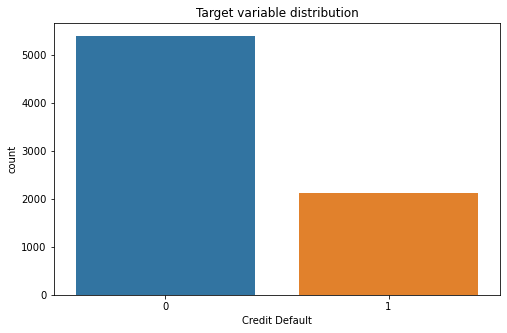

In [16]:
plt.figure(figsize=(8, 5))
sns.countplot(x="Credit Default", data=df_train)

plt.title("Target variable distribution")
plt.show()

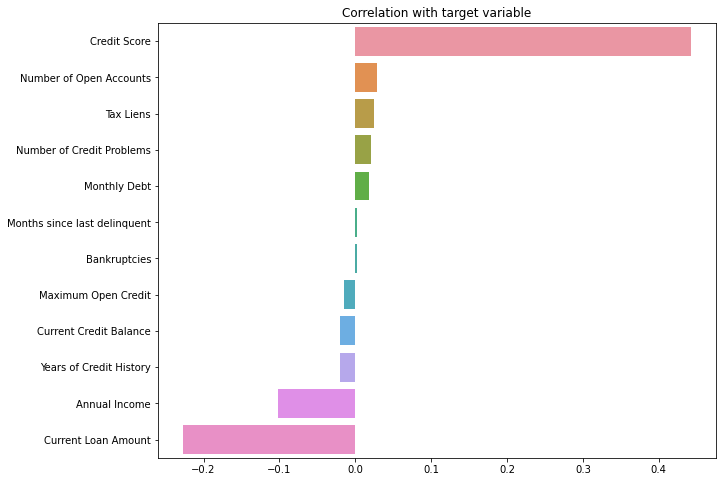

In [17]:
corr_with_target = df_train.corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title("Correlation with target variable")
plt.show()

Отбор признаков с заметной связью по шкале Чеддока:

In [18]:
corr_with_target[corr_with_target > 0.3]

Credit Score    0.44205
Name: Credit Default, dtype: float64

 Количественные признаки:

In [19]:
feature_num_names = df_train.drop('Credit Default', axis=1).select_dtypes(include=['float64', 'int64']).\
        columns.tolist()
feature_num_names

['Annual Income',
 'Tax Liens',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Number of Credit Problems',
 'Months since last delinquent',
 'Bankruptcies',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score']

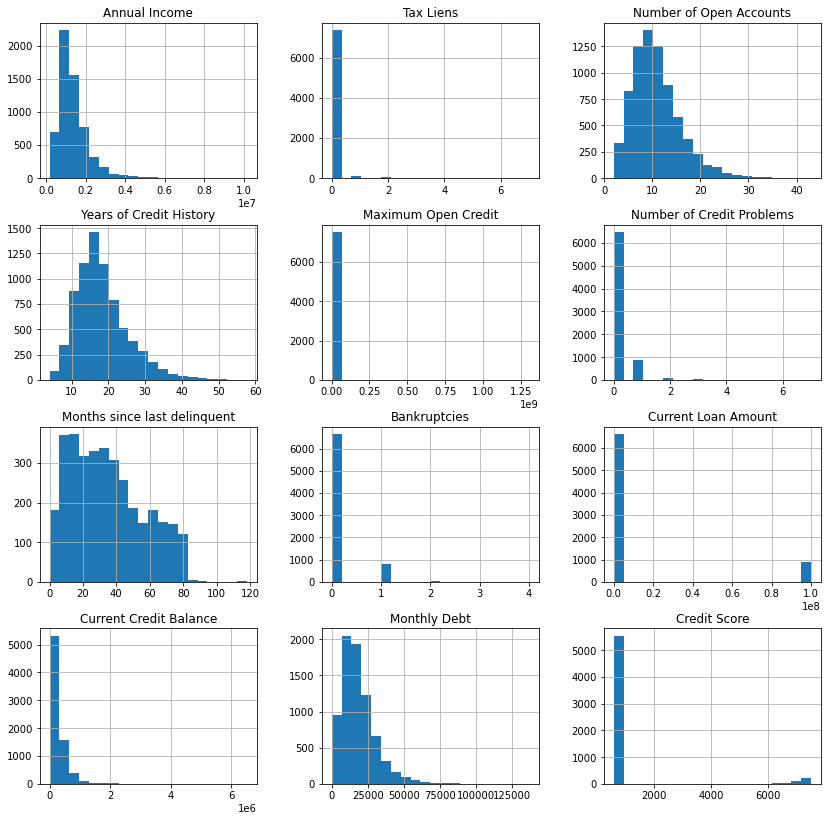

In [20]:
df_train[feature_num_names].hist(figsize=(14,14), bins=20, grid=True);

Категориальные признаки:

In [21]:
feature_cat_names = df_train.select_dtypes(include='object').columns.tolist()
feature_cat_names

['Home Ownership', 'Years in current job', 'Purpose', 'Term']

In [22]:
df_train['Home Ownership'].value_counts()

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64

In [23]:
df_test['Home Ownership'].value_counts()

Home Mortgage    1225
Rent             1020
Own Home          248
Have Mortgage       7
Name: Home Ownership, dtype: int64

In [24]:
df_train['Years in current job'].value_counts()

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64

In [25]:
df_test['Years in current job'].value_counts()

10+ years    810
3 years      228
2 years      212
< 1 year     207
5 years      169
1 year       153
4 years      152
7 years      140
6 years      137
8 years      107
9 years       99
Name: Years in current job, dtype: int64

In [26]:
df_train['Purpose'].value_counts()

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation                   8
renewable energy           2
Name: Purpose, dtype: int64

In [27]:
df_test['Purpose'].value_counts()

debt consolidation      1973
other                    240
home improvements        140
buy a car                 34
business loan             30
medical bills             27
buy house                 19
take a trip               14
major purchase             9
small business             5
educational expenses       3
vacation                   3
wedding                    2
moving                     1
Name: Purpose, dtype: int64

In [28]:
df_train['Term'].value_counts()

Short Term    5556
Long Term     1944
Name: Term, dtype: int64

In [29]:
df_test['Term'].value_counts()

Short Term    1861
Long Term      639
Name: Term, dtype: int64

Признак 'Term' является бинарным.

Категориальные признаки в тестовом датасете не принимают значений, отличных от тренировочного датасета.

### Обработка пропусков

Решение о выборе метода обработки пропусков делается на основе анализа природной сущности признаков.

Абсолютное количество пропусков:

In [30]:
df_train.isna().sum()

Home Ownership                     0
Annual Income                   1557
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
dtype: int64

Процентное количество пропусков:

In [31]:
round(df_train.isna().mean() * 100, 2)

Home Ownership                   0.00
Annual Income                   20.76
Years in current job             4.95
Tax Liens                        0.00
Number of Open Accounts          0.00
Years of Credit History          0.00
Maximum Open Credit              0.00
Number of Credit Problems        0.00
Months since last delinquent    54.41
Bankruptcies                     0.19
Purpose                          0.00
Term                             0.00
Current Loan Amount              0.00
Current Credit Balance           0.00
Monthly Debt                     0.00
Credit Score                    20.76
Credit Default                   0.00
dtype: float64

Рассматриваемые признаки: 'Annual Income', 'Years in current job', 'Months since last delinquent', 'Bankruptcies', 'Credit Score'.

#### Обработка пропусков признака 'Annual Income'

Вариант 1. Замена пропущенных значений признака медианой:

In [32]:
df_train['Annual Income'].fillna(df_train['Annual Income'].median(), inplace=True)
df_test['Annual Income'].fillna(df_train['Annual Income'].median(), inplace=True)

#### Обработка пропусков признака 'Years in current job'

Вариант 2. Замена пропущенных значений признака модой:

In [33]:
df_train['Years in current job'].fillna(df_train['Years in current job'].mode()[0], inplace=True)
df_test['Years in current job'].fillna(df_train['Years in current job'].mode()[0], inplace=True)

#### Обработка пропусков признака 'Months since last delinquent'

Вариант 3. Замена пропущенных значений признака медианой:

In [34]:
df_train['Months since last delinquent'].fillna(df_train['Months since last delinquent'].median(), inplace=True)
df_test['Months since last delinquent'].fillna(df_train['Months since last delinquent'].median(), inplace=True)

#### Обработка пропусков признака 'Bankruptcies'

Вариант 4. Замена пропущенных значений признака медианой:

In [35]:
df_train['Bankruptcies'].fillna(df_train['Bankruptcies'].median(), inplace=True)
df_test['Bankruptcies'].fillna(df_train['Bankruptcies'].median(), inplace=True)

#### Обработка пропусков признака 'Credit Score'

Вариант 5. Замена пропущенных значений признака медианой:

In [36]:
df_train['Credit Score'].fillna(df_train['Credit Score'].median(), inplace=True)
df_test['Credit Score'].fillna(df_train['Credit Score'].median(), inplace=True)

In [37]:
df_train.isna().sum()

Home Ownership                  0
Annual Income                   0
Years in current job            0
Tax Liens                       0
Number of Open Accounts         0
Years of Credit History         0
Maximum Open Credit             0
Number of Credit Problems       0
Months since last delinquent    0
Bankruptcies                    0
Purpose                         0
Term                            0
Current Loan Amount             0
Current Credit Balance          0
Monthly Debt                    0
Credit Score                    0
Credit Default                  0
dtype: int64

In [38]:
df_test.isna().sum()

Home Ownership                  0
Annual Income                   0
Years in current job            0
Tax Liens                       0
Number of Open Accounts         0
Years of Credit History         0
Maximum Open Credit             0
Number of Credit Problems       0
Months since last delinquent    0
Bankruptcies                    0
Purpose                         0
Term                            0
Current Loan Amount             0
Current Credit Balance          0
Monthly Debt                    0
Credit Score                    0
dtype: int64

### Обработка категориальных признаков

Рассматриваемые признаки: 'Home Ownership', 'Years in current job', 'Purpose', 'Term'.

#### Создание вспомогательных датафреймов

Создание оригинальных датафреймов категориальных признаков:

In [39]:
df_train_cat_features = df_train[feature_cat_names].copy()
df_test_cat_features = df_test[feature_cat_names].copy()

Создание датафреймов категориальных признаков, преобразованных методом One-Hot Encoding:

In [40]:
df_train_cat_features_OHE = pd.DataFrame()
df_test_cat_features_OHE = pd.DataFrame()

In [41]:
df_train_cat_features_OHE.info()

<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Empty DataFrame

In [42]:
df_test_cat_features_OHE.info()

<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Empty DataFrame

#### Обработка признака 'Home Ownership'

Вариант 6. Преобразование категориальных значений признака в количественные бинарные методом One-Hot Encoding:

In [43]:
pd.get_dummies(df_train['Home Ownership'])

,Have Mortgage,Home Mortgage,Own Home,Rent
0,0,0,1,0
1,0,0,1,0
2,0,1,0,0
3,0,0,1,0
4,0,0,0,1
...,...,...,...,...
7495,0,0,0,1
7496,0,1,0,0
7497,0,0,0,1
7498,0,1,0,0


In [44]:
df_train_cat_features_OHE = pd.concat([df_train_cat_features_OHE, pd.get_dummies(df_train['Home Ownership'])], axis=1)
df_test_cat_features_OHE = pd.concat([df_test_cat_features_OHE, pd.get_dummies(df_test['Home Ownership'])], axis=1)

#### Обработка признака 'Years in current job'

Вариант 7. Преобразование категориальных значений признака в количественные бинарные методом One-Hot Encoding:

In [45]:
pd.get_dummies(df_train['Years in current job'])

,1 year,10+ years,2 years,3 years,4 years,5 years,6 years,7 years,8 years,9 years,< 1 year
0,0,1,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...
7495,0,0,0,0,0,0,0,0,0,0,1
7496,1,0,0,0,0,0,0,0,0,0,0
7497,0,0,0,0,0,0,1,0,0,0,0
7498,0,1,0,0,0,0,0,0,0,0,0


In [46]:
df_train_cat_features_OHE = pd.concat([df_train_cat_features_OHE, pd.get_dummies(df_train['Years in current job'])], axis=1)
df_test_cat_features_OHE = pd.concat([df_test_cat_features_OHE, pd.get_dummies(df_test['Years in current job'])], axis=1)

#### Обработка признака 'Purpose'

Вариант 8. Преобразование категориальных значений признака в количественные бинарные методом One-Hot Encoding:

In [47]:
pd.get_dummies(df_train['Purpose'])

,business loan,buy a car,buy house,debt consolidation,educational expenses,home improvements,major purchase,medical bills,moving,other,renewable energy,small business,take a trip,vacation,wedding
0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7495,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
7496,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
7497,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
7498,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [48]:
df_train_cat_features_OHE = pd.concat([df_train_cat_features_OHE, pd.get_dummies(df_train['Purpose'])], axis=1)
df_test_cat_features_OHE = pd.concat([df_test_cat_features_OHE, pd.get_dummies(df_test['Purpose'])], axis=1)

#### Обработка признака 'Term'

Вариант 9. Преобразование категориальных значений признака в количественные бинарные методом Label Encoding:

In [49]:
df_train['Term'] = df_train['Term'].replace({'Short Term':0, 'Long Term':1})
df_test['Term'] = df_test['Term'].replace({'Short Term':0, 'Long Term':1})

In [50]:
df_train_cat_features.drop('Term', axis=1, inplace=True)
df_test_cat_features.drop('Term', axis=1, inplace=True)

In [51]:
df_train_cat_features_OHE.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 30 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   Have Mortgage         7500 non-null   uint8
 1   Home Mortgage         7500 non-null   uint8
 2   Own Home              7500 non-null   uint8
 3   Rent                  7500 non-null   uint8
 4   1 year                7500 non-null   uint8
 5   10+ years             7500 non-null   uint8
 6   2 years               7500 non-null   uint8
 7   3 years               7500 non-null   uint8
 8   4 years               7500 non-null   uint8
 9   5 years               7500 non-null   uint8
 10  6 years               7500 non-null   uint8
 11  7 years               7500 non-null   uint8
 12  8 years               7500 non-null   uint8
 13  9 years               7500 non-null   uint8
 14  < 1 year              7500 non-null   uint8
 15  business loan         7500 non-null   uint8
 16  buy a 

In [52]:
df_test_cat_features_OHE.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 29 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   Have Mortgage         2500 non-null   uint8
 1   Home Mortgage         2500 non-null   uint8
 2   Own Home              2500 non-null   uint8
 3   Rent                  2500 non-null   uint8
 4   1 year                2500 non-null   uint8
 5   10+ years             2500 non-null   uint8
 6   2 years               2500 non-null   uint8
 7   3 years               2500 non-null   uint8
 8   4 years               2500 non-null   uint8
 9   5 years               2500 non-null   uint8
 10  6 years               2500 non-null   uint8
 11  7 years               2500 non-null   uint8
 12  8 years               2500 non-null   uint8
 13  9 years               2500 non-null   uint8
 14  < 1 year              2500 non-null   uint8
 15  business loan         2500 non-null   uint8
 16  buy a 

In [53]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 7500 non-null   float64
 2   Years in current job          7500 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  7500 non-null   float64
 9   Bankruptcies                  7500 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   int64  
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [54]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                2500 non-null   object 
 1   Annual Income                 2500 non-null   float64
 2   Years in current job          2500 non-null   object 
 3   Tax Liens                     2500 non-null   float64
 4   Number of Open Accounts       2500 non-null   float64
 5   Years of Credit History       2500 non-null   float64
 6   Maximum Open Credit           2500 non-null   float64
 7   Number of Credit Problems     2500 non-null   float64
 8   Months since last delinquent  2500 non-null   float64
 9   Bankruptcies                  2500 non-null   float64
 10  Purpose                       2500 non-null   object 
 11  Term                          2500 non-null   int64  
 12  Current Loan Amount           2500 non-null   float64
 13  Cur

### Выделение целевой переменной и групп признаков

Целевая переменная:

In [55]:
target_name = 'Credit Default'

Количественные признаки с заполненными пропусками:

In [56]:
feature_num_names = df_train.drop('Credit Default', axis=1).select_dtypes(include=['float64', 'int64', 'uint8']).\
        columns.tolist()
feature_num_names

['Annual Income',
 'Tax Liens',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Number of Credit Problems',
 'Months since last delinquent',
 'Bankruptcies',
 'Term',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score']

Оригинальные категориальные признаки:

In [57]:
feature_cat_names = df_train.select_dtypes(include='object').columns.tolist()
feature_cat_names

['Home Ownership', 'Years in current job', 'Purpose']

Категориальные признаки, преобразованные методом One-Hot Encoding:

In [58]:
feature_cat_names_OHE = df_train_cat_features_OHE.columns.tolist()
feature_cat_names_OHE

['Have Mortgage',
 'Home Mortgage',
 'Own Home',
 'Rent',
 '1 year',
 '10+ years',
 '2 years',
 '3 years',
 '4 years',
 '5 years',
 '6 years',
 '7 years',
 '8 years',
 '9 years',
 '< 1 year',
 'business loan',
 'buy a car',
 'buy house',
 'debt consolidation',
 'educational expenses',
 'home improvements',
 'major purchase',
 'medical bills',
 'moving',
 'other',
 'renewable energy',
 'small business',
 'take a trip',
 'vacation',
 'wedding']

Датафрейм 1. Количественные признаки с заполненными пропусками + оригинальные категориальные признаки:

In [59]:
df_train_1 = pd.concat([df_train[feature_num_names], df_train_cat_features], axis=1)
df_test_1 = pd.concat([df_test[feature_num_names], df_test_cat_features], axis=1)
feature_names_1 = feature_num_names + feature_cat_names
feature_names_1

['Annual Income',
 'Tax Liens',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Number of Credit Problems',
 'Months since last delinquent',
 'Bankruptcies',
 'Term',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score',
 'Home Ownership',
 'Years in current job',
 'Purpose']

Датафрейм 2. Количественные признаки с заполненными пропусками + категориальные признаки, преобразованные методом One-Hot Encoding::

In [60]:
df_train_2 = pd.concat([df_train[feature_num_names], df_train_cat_features_OHE], axis=1)
df_test_2 = pd.concat([df_test[feature_num_names], df_test_cat_features_OHE], axis=1)
feature_names_2 = feature_num_names + feature_cat_names_OHE
feature_names_2

['Annual Income',
 'Tax Liens',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Number of Credit Problems',
 'Months since last delinquent',
 'Bankruptcies',
 'Term',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score',
 'Have Mortgage',
 'Home Mortgage',
 'Own Home',
 'Rent',
 '1 year',
 '10+ years',
 '2 years',
 '3 years',
 '4 years',
 '5 years',
 '6 years',
 '7 years',
 '8 years',
 '9 years',
 '< 1 year',
 'business loan',
 'buy a car',
 'buy house',
 'debt consolidation',
 'educational expenses',
 'home improvements',
 'major purchase',
 'medical bills',
 'moving',
 'other',
 'renewable energy',
 'small business',
 'take a trip',
 'vacation',
 'wedding']

### Разбиение на обучающие и тестовые выборки

In [61]:
X1 = df_train_1[feature_names_1]
y1 = df_train[target_name]

X1_train, X1_val, y1_train, y1_val = train_test_split(X1, y1, shuffle=True, test_size=0.2, random_state=13)

In [62]:
X2 = df_train_2[feature_names_2]
y2 = df_train[target_name]

X2_train, X2_val, y2_train, y2_val = train_test_split(X2, y2, shuffle=True, test_size=0.2, random_state=13)

### Построение и оценка базовых моделей

#### Модель логистической регрессии

In [63]:
model_lr = LogisticRegression()
model_lr.fit(X2_train[feature_names_2], y2_train)

y_train_pred = model_lr.predict(X2_train[feature_names_2])
y_test_pred = model_lr.predict(X2_val[feature_names_2])

get_classification_report(y2_train, y_train_pred, y2_val, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.75      0.98      0.85      4281
           1       0.82      0.20      0.32      1719

    accuracy                           0.76      6000
   macro avg       0.79      0.59      0.59      6000
weighted avg       0.77      0.76      0.70      6000

TEST

              precision    recall  f1-score   support

           0       0.78      0.99      0.87      1106
           1       0.85      0.23      0.36       394

    accuracy                           0.79      1500
   macro avg       0.81      0.61      0.61      1500
weighted avg       0.80      0.79      0.74      1500

CONFUSION MATRIX

col_0              0   1
Credit Default          
0               1090  16
1                305  89


#### Модель k ближайших соседей

In [64]:
model_knn = KNeighborsClassifier()
model_knn.fit(X2_train[feature_names_2], y2_train)

y_train_pred = model_knn.predict(X2_train[feature_names_2])
y_test_pred = model_knn.predict(X2_val[feature_names_2])

get_classification_report(y2_train, y_train_pred, y2_val, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.80      0.91      0.85      4281
           1       0.66      0.45      0.53      1719

    accuracy                           0.78      6000
   macro avg       0.73      0.68      0.69      6000
weighted avg       0.76      0.78      0.76      6000

TEST

              precision    recall  f1-score   support

           0       0.77      0.86      0.81      1106
           1       0.41      0.27      0.33       394

    accuracy                           0.70      1500
   macro avg       0.59      0.57      0.57      1500
weighted avg       0.67      0.70      0.68      1500

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               948  158
1               286  108


#### Модель XGBoost

In [65]:
X2_train.rename(columns = {'< 1 year' : 'less 1 year',}, inplace = True)
X2_val.rename(columns = {'< 1 year' : 'less 1 year',}, inplace = True)
feature_names_2[feature_names_2.index('< 1 year')] = 'less 1 year'

/Users/alexander/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [66]:
model_xgb = xgb.XGBClassifier(random_state=13)
model_xgb.fit(X2_train[feature_names_2], y2_train)

y_train_pred = model_xgb.predict(X2_train[feature_names_2])
y_test_pred = model_xgb.predict(X2_val[feature_names_2])

get_classification_report(y2_train, y_train_pred, y2_val, y_test_pred)

[01:18:03] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/alexander/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


TRAIN

              precision    recall  f1-score   support

           0       0.95      1.00      0.97      4281
           1       0.99      0.86      0.92      1719

    accuracy                           0.96      6000
   macro avg       0.97      0.93      0.95      6000
weighted avg       0.96      0.96      0.96      6000

TEST

              precision    recall  f1-score   support

           0       0.80      0.92      0.86      1106
           1       0.62      0.36      0.45       394

    accuracy                           0.77      1500
   macro avg       0.71      0.64      0.66      1500
weighted avg       0.75      0.77      0.75      1500

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1020   86
1                253  141


#### Модель LightGBM

In [67]:
model_lgbm = lgbm.LGBMClassifier(random_state=13)
model_lgbm.fit(X2_train[feature_names_2], y2_train)

y_train_pred = model_lgbm.predict(X2_train[feature_names_2])
y_test_pred = model_lgbm.predict(X2_val[feature_names_2])

get_classification_report(y2_train, y_train_pred, y2_val, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.88      1.00      0.93      4281
           1       0.98      0.65      0.78      1719

    accuracy                           0.90      6000
   macro avg       0.93      0.82      0.86      6000
weighted avg       0.91      0.90      0.89      6000

TEST

              precision    recall  f1-score   support

           0       0.80      0.94      0.87      1106
           1       0.68      0.36      0.47       394

    accuracy                           0.79      1500
   macro avg       0.74      0.65      0.67      1500
weighted avg       0.77      0.79      0.76      1500

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1038   68
1                252  142


#### Модель CatBoost

Приведение типов:

In [68]:
for name in feature_cat_names:
    X1_train[name] = pd.Categorical(X1_train[name])
    X1_val[name] = pd.Categorical(X1_val[name])

<ipython-input-68-0dd612693da7>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X1_train[name] = pd.Categorical(X1_train[name])
<ipython-input-68-0dd612693da7>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X1_val[name] = pd.Categorical(X1_val[name])


In [69]:
X1_train[feature_cat_names].dtypes

Home Ownership          category
Years in current job    category
Purpose                 category
dtype: object

In [70]:
X1_val[feature_cat_names].dtypes

Home Ownership          category
Years in current job    category
Purpose                 category
dtype: object

In [71]:
model_catb = catb.CatBoostClassifier(silent=True, cat_features=feature_cat_names, random_state=13)
model_catb.fit(X1_train[feature_names_1], y1_train)

y_train_pred = model_catb.predict(X1_train[feature_names_1])
y_test_pred = model_catb.predict(X1_val[feature_names_1])

get_classification_report(y1_train, y_train_pred, y1_val, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.82      0.99      0.90      4281
           1       0.96      0.46      0.62      1719

    accuracy                           0.84      6000
   macro avg       0.89      0.73      0.76      6000
weighted avg       0.86      0.84      0.82      6000

TEST

              precision    recall  f1-score   support

           0       0.80      0.97      0.88      1106
           1       0.78      0.32      0.46       394

    accuracy                           0.80      1500
   macro avg       0.79      0.64      0.67      1500
weighted avg       0.79      0.80      0.77      1500

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1070   36
1                267  127


### Выбор лучшей модели и подбор гиперпараметров

Лучшая модель:

In [72]:
model_catb = catb.CatBoostClassifier(class_weights=[1, 3.5], silent=True, cat_features=feature_cat_names, random_state=13)

Подбор гиперпараметров:

In [73]:
params = {'n_estimators':[40, 50, 100, 200, 500, 700, 1000, 1500],
          'max_depth':[1, 3, 5, 7]}

In [74]:
cv=KFold(n_splits=5, random_state=13, shuffle=True)

Приведение типов:

In [76]:
for name in feature_cat_names:
    X1[name] = pd.Categorical(X1[name])

In [77]:
%%time

rs = RandomizedSearchCV(model_catb, params, scoring='f1', cv=cv, n_jobs=-1)
rs.fit(X1, y1)

CPU times: user 1.25 s, sys: 230 ms, total: 1.48 s
Wall time: 2min 46s


RandomizedSearchCV(cv=KFold(n_splits=5, random_state=13, shuffle=True),
                   estimator=<catboost.core.CatBoostClassifier object at 0x7f9e4c68fb20>,
                   n_jobs=-1,
                   param_distributions={'max_depth': [1, 3, 5, 7],
                                        'n_estimators': [40, 50, 100, 200, 500,
                                                         700, 1000, 1500]},
                   scoring='f1')

In [78]:
rs.best_params_

{'n_estimators': 100, 'max_depth': 5}

In [79]:
rs.best_score_

0.5408237778326029

Обучение и оценка финальной модели:

In [80]:
%%time

final_model = catb.CatBoostClassifier(n_estimators=100, max_depth=5,
                                      silent=True, cat_features=feature_cat_names,
                                      random_state=13)
final_model.fit(X1_train, y1_train)

y_train_pred = final_model.predict(X1_train)
y_test_pred = final_model.predict(X1_val)

get_classification_report(y1_train, y_train_pred, y1_val, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.79      0.98      0.87      4281
           1       0.89      0.33      0.48      1719

    accuracy                           0.80      6000
   macro avg       0.84      0.66      0.68      6000
weighted avg       0.82      0.80      0.76      6000

TEST

              precision    recall  f1-score   support

           0       0.79      0.98      0.88      1106
           1       0.81      0.29      0.43       394

    accuracy                           0.80      1500
   macro avg       0.80      0.63      0.65      1500
weighted avg       0.80      0.80      0.76      1500

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1079   27
1                279  115
CPU times: user 859 ms, sys: 98.8 ms, total: 958 ms
Wall time: 484 ms


### Дальнейшее улучшение модели

Снижение степени переобучения:

In [82]:
%%time

final_model = catb.CatBoostClassifier(n_estimators=100, max_depth=5,
                                      l2_leaf_reg=10, silent=True, 
                                      cat_features=feature_cat_names,
                                      random_state=13)
final_model.fit(X1_train, y1_train)

y_train_pred = final_model.predict(X1_train)
y_test_pred = final_model.predict(X1_val)

get_classification_report(y1_train, y_train_pred, y1_val, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.75      1.00      0.86      4281
           1       1.00      0.18      0.31      1719

    accuracy                           0.77      6000
   macro avg       0.88      0.59      0.58      6000
weighted avg       0.82      0.77      0.70      6000

TEST

              precision    recall  f1-score   support

           0       0.78      1.00      0.88      1106
           1       1.00      0.20      0.34       394

    accuracy                           0.79      1500
   macro avg       0.89      0.60      0.61      1500
weighted avg       0.84      0.79      0.73      1500

CONFUSION MATRIX

col_0              0   1
Credit Default          
0               1106   0
1                314  80
CPU times: user 860 ms, sys: 92.3 ms, total: 952 ms
Wall time: 467 ms


Отбор признаков по степени важности:

/Users/alexander/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


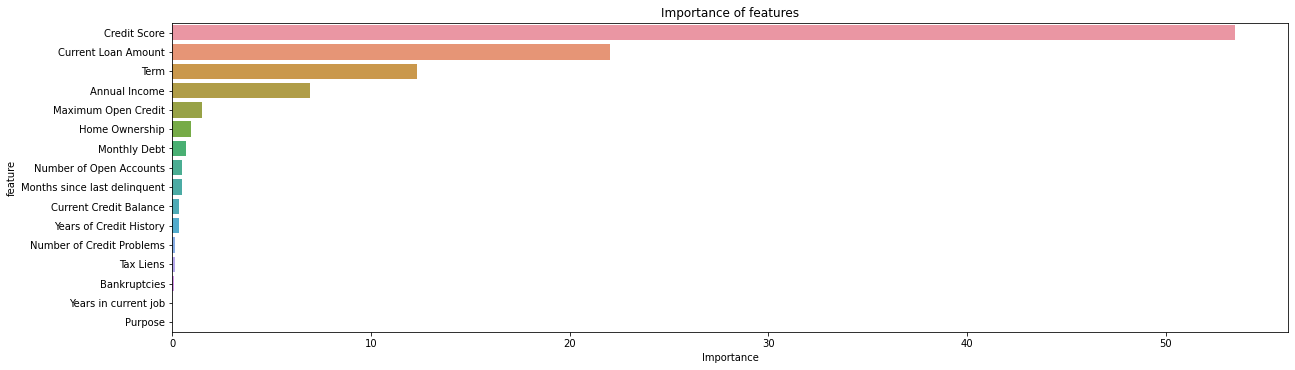

In [83]:
important_features_top = show_feature_importances(X1_train.columns, final_model.feature_importances_,get_top=8)

In [84]:
important_features_top

['Credit Score',
 'Current Loan Amount',
 'Term',
 'Annual Income',
 'Maximum Open Credit',
 'Home Ownership',
 'Monthly Debt',
 'Number of Open Accounts']

In [85]:
important_cat_features_top = [feature for feature in feature_cat_names if feature in important_features_top]
important_cat_features_top

['Home Ownership']

Финальная модель:

In [86]:
%%time

final_model = catb.CatBoostClassifier(n_estimators=100, max_depth=5,
                                      l2_leaf_reg=10, silent=True, 
                                      cat_features=important_cat_features_top,
                                      random_state=13)
final_model.fit(X1_train[important_features_top], y1_train)

y_train_pred = final_model.predict(X1_train[important_features_top])
y_test_pred = final_model.predict(X1_val[important_features_top])

get_classification_report(y1_train, y_train_pred, y1_val, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.75      1.00      0.86      4281
           1       1.00      0.18      0.31      1719

    accuracy                           0.77      6000
   macro avg       0.88      0.59      0.58      6000
weighted avg       0.82      0.77      0.70      6000

TEST

              precision    recall  f1-score   support

           0       0.78      1.00      0.88      1106
           1       1.00      0.20      0.34       394

    accuracy                           0.79      1500
   macro avg       0.89      0.60      0.61      1500
weighted avg       0.84      0.79      0.73      1500

CONFUSION MATRIX

col_0              0   1
Credit Default          
0               1106   0
1                314  80
CPU times: user 605 ms, sys: 82.4 ms, total: 687 ms
Wall time: 379 ms


Прогноз финальной модели на тестовом датасете: 

In [97]:
%%time

final_model = catb.CatBoostClassifier(n_estimators=100, max_depth=5,
                                      l2_leaf_reg=10, silent=True, 
                                      cat_features=important_cat_features_top,
                                      random_state=13)
final_model.fit(X1[important_features_top], y1)

y_pred = final_model.predict(df_test[important_features_top])
y_pred

CPU times: user 529 ms, sys: 72.3 ms, total: 602 ms
Wall time: 453 ms


array([0, 0, 1, ..., 0, 0, 1])

In [98]:
preds = pd.DataFrame()
preds['Id'] = df_test.index
preds['Price'] = y_pred
preds.head()

,Id,Price
0,0,0
1,1,0
2,2,1
3,3,0
4,4,0


In [99]:
preds.to_csv('AVDunaev_predictions_2.csv', index=False)